<p style="color:red;font-size:32px;text-align:center"> <b>Social Network Graph Link Prediction : Part 3</b> </p>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns#Plots
import gc
from IPython.display import display, Image
import graphviz
import pickle

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [2]:
random.seed(9)
np.random.seed(9)

# 7. ML Modelling

__LOADING THE DATA__

In [3]:
file_path = 'processed/features/features_train_test.h5'

train_df = pd.read_hdf(file_path, key='train_df')
test_df = pd.read_hdf(file_path, key='test_df')

print(f"shape of train_df : {train_df.shape}")
print(f"shape of test_df : {test_df.shape}")

shape of train_df : (100000, 59)
shape of test_df : (50000, 59)


In [4]:
train_df.sample(5)

,source,destination,edge_indicator,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,follows_back,same_scc,same_wcc,...,svd_vs5,svd_vs6,svd_vd1,svd_vd2,svd_vd3,svd_vd4,svd_vd5,svd_vd6,svd_dot_u,svd_dot_v
60612,1313296,890284,0,0.0,0.0,0.0,0.0,0,0,1,...,6.399341e-14,-3.028906e-16,-7.378852e-16,-8.398481e-14,1.058231e-14,-3.168810e-17,2.222558e-16,-3.948531e-19,7.822191e-24,9.743600e-24
3517,259199,579543,1,0.0,0.0,0.0,0.0,1,1,1,...,2.354471e-14,-3.826391e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.645868e-32,0.000000e+00
50420,1858388,1026665,0,0.0,0.0,0.0,0.0,0,0,0,...,1.110114e-13,-4.381131e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.598520e-21,0.000000e+00
85444,1171147,723421,0,0.0,0.0,0.0,0.0,0,0,1,...,7.305218e-14,-3.733344e-14,1.598669e-22,8.983952e-22,1.329603e-22,3.412752e-21,-8.566070e-22,5.947053e-22,-5.737596e-26,4.308272e-29
27463,1687548,384161,1,0.0,0.0,0.0,0.0,1,1,1,...,0.000000e+00,0.000000e+00,-5.774604e-11,-1.270297e-09,1.236405e-10,-3.138128e-11,4.328761e-10,-1.357487e-13,-8.130840e-28,0.000000e+00


In [5]:
print(f"Columns in the data : {train_df.columns}")

Columns in the data : Index(['source', 'destination', 'edge_indicator', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'follows_back', 'same_scc', 'same_wcc', 'adar_index', 'spl_coef',
       'prefer_attach', 'num_followers_source', 'num_followers_dest',
       'num_followees_source', 'num_followees_dest', 'inter_followers',
       'inter_followees', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_source', 'page_rank_dest',
       'katz_source', 'katz_dest', 'hub_source', 'hub_dest', 'auth_source',
       'auth_dest', 'svd_us1', 'svd_us2', 'svd_us3', 'svd_us4', 'svd_us5',
       'svd_us6', 'svd_ud1', 'svd_ud2', 'svd_ud3', 'svd_ud4', 'svd_ud5',
       'svd_ud6', 'svd_vs1', 'svd_vs2', 'svd_vs3', 'svd_vs4', 'svd_vs5',
       'svd_vs6', 'svd_vd1', 'svd_vd2', 'svd_vd3', 'svd_vd4', 'svd_vd5',
       'svd_vd6', 'svd_dot_u', 'svd_dot_v'],
      dtype='object')


In [6]:
Ytrain = train_df.edge_indicator.values
Ytest = test_df.edge_indicator.values

Xtrain = train_df.drop(['source', 'destination', 'edge_indicator'], axis=1)
Xtest = test_df.drop(['source', 'destination', 'edge_indicator'], axis=1)

In [7]:
columns = np.array(Xtrain.columns)
print(f"Number of features to be fed into models : {Xtrain.shape[1]}")

Number of features to be fed into models : 56


__UTILS__

In [8]:
def plot_tsne(perplexity=None, X=Xtrain, Y=Ytrain):
    
    X_2d = TSNE(n_components=2, perplexity=perplexity).fit_transform(X)
    df = pd.DataFrame({'x' : X_2d[:, 0], 'y' : X_2d[:, 1], 'label' : Y})
    sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8,
           palette="Set1", markers=['^', 's'])
    plt.title(f"perplexity={perplexity}", fontsize=20, color='r')
    plt.show()
    
    

In [9]:
def plot_confusion_matrix(model=None, y_pred=None, x_test=Xtest, y_true=Ytest, labels=['no_edge', 'has_edge']):
    
    if model is not None and y_pred is None:
        y_pred = model.predict(x_test)
    
    C = confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
    
    
    figures = [('Confusion Matrix', C), 
               ('Precision Matrix', C/C.sum(0)),
               ('Recall Matrix', C/C.sum(1))]
    
    for ax, (fig_title, fig_data) in zip(axes, figures):
        
        sns.heatmap(fig_data,
                    fmt='.3f',
                    annot=True,
                    cmap='Spectral_r',
                    linewidths=0.5,
                    xticklabels=labels,
                    yticklabels=labels,
                    ax=ax)
        ax.set_title(fig_title, fontsize=12)
        ax.set_xlabel('PREDICTED_LABEL', fontsize=10)
        ax.set_ylabel('TRUE_LABEL', fontsize=10)
    
    fig.tight_layout()
    plt.show()

In [10]:
models_eval_dict = {'columns' : ['PRECISION', "RECALL", 'ACCURACY', 'LOG_LOSS', "F1_SCORE"]}

def get_metrics(model, x_train=Xtrain, y_train=Ytrain, x_test=Xtest, y_test=Ytest,\
                 col_names=models_eval_dict['columns'], plot_conf=True, name=None):
    
    sig_clf = CalibratedClassifierCV(model, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    test_sig_probs = sig_clf.predict_proba(x_test)
    y_pred = test_sig_probs.argmax(1)
    
    pr = round(precision_score(y_test, y_pred), 4)
    rec = round(recall_score(y_test, y_pred), 4)
    acc = round(accuracy_score(y_test, y_pred), 4)
    lgl = round(log_loss(y_test, test_sig_probs), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    
    metrics = [pr, rec, acc, lgl, f1]
    display(pd.DataFrame([metrics], columns=col_names, index=[name]))
    
    if plot_conf:
        plot_confusion_matrix(y_pred=y_pred)
    
    return metrics

In [11]:
def plot_top_features(coef, feature_names=columns, plot_f=10):
    
    coef = coef.ravel()
    feat_idxs = np.abs(coef).argsort()[::-1][:plot_f]
    features = columns[feat_idxs]
    
    plt.figure(figsize=(12, 7))
    plt.title('FEATURE IMPORTANCES', fontsize=15, color='red')
    sns.barplot(x=coef[feat_idxs], y=features)
    plt.xlabel('IMPORTANCE', fontsize=15, color='green')
    plt.ylabel('FEATURE', fontsize=15, color='green')
    #https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
    for i, c in enumerate(coef[feat_idxs]):
        plt.text(c, i, f'{c:.3f}', color='blue', fontweight='bold')
        
    plt.tight_layout()
    plt.show()
    

In [12]:
def render_graph(model, depth, features, filename):
    
    dot_data = export_graphviz(model, out_file=None, max_depth=depth, feature_names=features)
    graph = graphviz.Source(dot_data)
    graph.render(filename)

## 7.1 Data Visualization

* __<font color='red'>NOTE : Always run t-SNE with multiple perplexities.</font>__

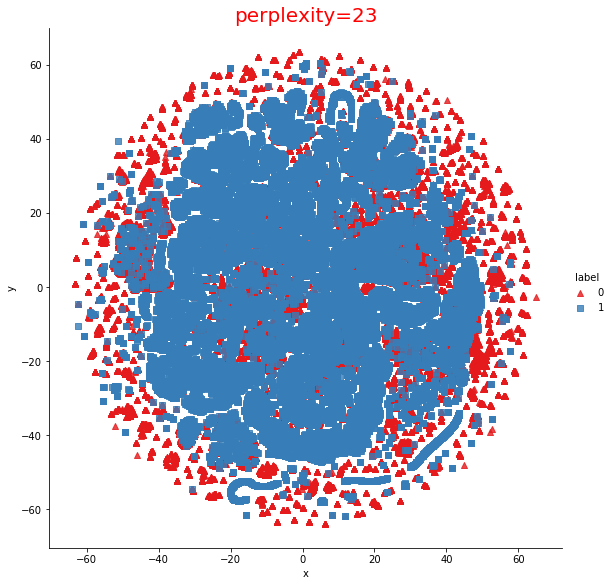

In [13]:
plot_tsne(perplexity=23)

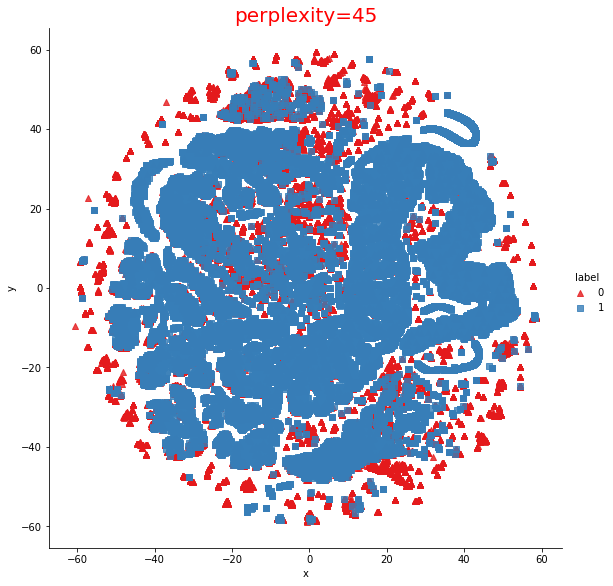

In [14]:
plot_tsne(perplexity=45)

__<font color='green'>OBSERVATIONS</font>__

* From the above plot, it looks as if two lumps sit on each other.
* A simple linear model should do well if we manage to fit a plane seperating the lumps.

## 7.2   K-Nearest Neighbors 

In [15]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [16]:
%%time

params = {'n_neighbors' : np.arange(1, 30, 2)}

knn_gs_cv = GridSearchCV(estimator=KNN(),
                         param_grid=params,
                         n_jobs=-1,
                         cv=3,
                         scoring='f1')

knn_gs_cv.fit(Xtrain, Ytrain)

Wall time: 2min 57s


In [17]:
knn_clf = knn_gs_cv.best_estimator_
knn_gs_cv.best_params_

{'n_neighbors': 5}

,PRECISION,RECALL,ACCURACY,LOG_LOSS,F1_SCORE
KNN,0.8796,0.7765,0.8352,0.4079,0.8248


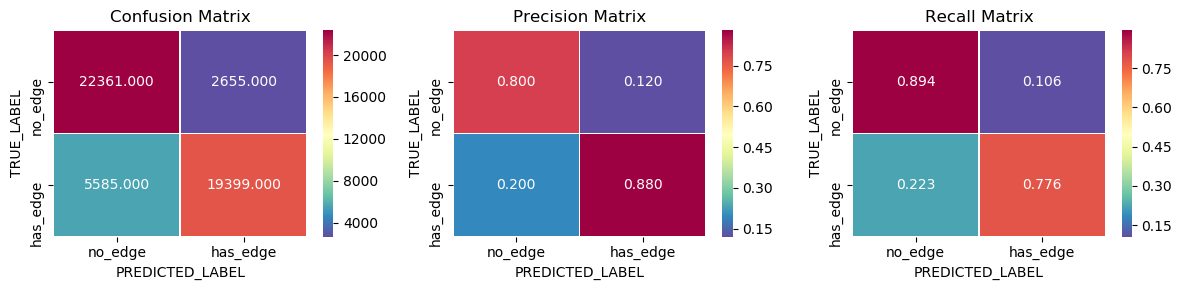

In [18]:
models_eval_dict['KNN'] = get_metrics(model=knn_clf, name='KNN')

__<font color='green'>OBSERVATIONS</font>__

* A Simple Neighbors approach seems to perfrom pretty well.
* The precision of `no_edge` and the recall of `had_egdge` has taken a hit.

## 7.3 Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

__PREPROCESSING__

* __<font color='green'> Some of the columns are on larger scale than other. </font>__
* __<font color='green'> this effects the interpretation and also making training harder to converge specially<br> when using regularization with weights having values on different scales. </font>__
* __<font color='green'> So lets normalize those features to scale of other features (0, 1). </font>__

In [46]:
norm_columns = ['adar_index',
                'num_followers_source',
                'num_followers_dest',
                'num_followees_source',
                'num_followees_dest',
                'inter_followers',
                'inter_followees',
                'weight_f4',
                'weight_f3',
                'weight_f2',
                'prefer_attach']

MAX = Xtrain[norm_columns].max().values
MIN = Xtrain[norm_columns].min().values

Xtrain_n = Xtrain.copy()
Xtest_n = Xtest.copy()

In [47]:
Xtrain_n[norm_columns] = (Xtrain[norm_columns] - MIN) / (MAX - MIN)
Xtest_n[norm_columns] = (Xtest[norm_columns] - MIN) / (MAX - MIN)

In [48]:
Xtrain_n.head(5)

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,follows_back,same_scc,same_wcc,adar_index,spl_coef,prefer_attach,...,svd_vs5,svd_vs6,svd_vd1,svd_vd2,svd_vd3,svd_vd4,svd_vd5,svd_vd6,svd_dot_u,svd_dot_v
0,0.0,0.1,0.0,0.3162,0,1,1,0.009284,0.3333,0.000027,...,1.714371e-15,-2.186059e-17,-7.900487e-17,-2.180678e-15,6.672402e-15,-9.077989e-18,2.064393e-17,-2.193502e-18,2.277850e-25,4.711636e-28
1,0.0,0.0,0.0,0.0000,0,1,1,0.000000,0.1250,0.000051,...,1.497324e-17,-8.054447e-20,-1.706638e-16,-4.254057e-13,1.021645e-14,-2.530460e-16,1.339739e-15,-1.477164e-18,1.484577e-33,1.057013e-28
2,0.0,0.0,0.0,0.0000,1,1,1,0.000000,0.1667,0.000107,...,0.000000e+00,0.000000e+00,6.793361e-21,6.492188e-21,1.565377e-21,5.229554e-21,-2.690145e-21,4.002407e-22,2.487609e-26,0.000000e+00
3,0.0,0.0,0.0,0.0000,0,0,1,0.000000,0.1000,0.000021,...,5.051600e-13,-5.977938e-15,-5.965856e-18,-1.359362e-16,6.457650e-16,-3.778001e-17,5.644067e-17,-3.892940e-20,1.848086e-25,5.090586e-26
4,0.0,0.0,0.0,0.0000,1,1,1,0.000000,0.1250,0.000097,...,5.206601e-17,-9.938860e-20,-2.614925e-14,-5.339986e-12,1.095667e-11,-6.533497e-14,2.796451e-12,-1.566683e-15,6.999931e-28,1.822458e-27


In [49]:
%%time 

params = {'C' : np.logspace(-5, 1, 7)}

log_reg_gs_cv = GridSearchCV(estimator=LogisticRegression(penalty='l1'),
                             param_grid=params,
                             n_jobs=-1,
                             cv=3,
                             scoring='f1')

log_reg_gs_cv.fit(Xtrain_n, Ytrain)

Wall time: 1min 13s


In [50]:
log_clf = log_reg_gs_cv.best_estimator_
log_reg_gs_cv.best_params_

{'C': 0.01}

,PRECISION,RECALL,ACCURACY,LOG_LOSS,F1_SCORE
LOGISTIC_REGRESSION,0.9874,0.8681,0.9285,0.2708,0.9239


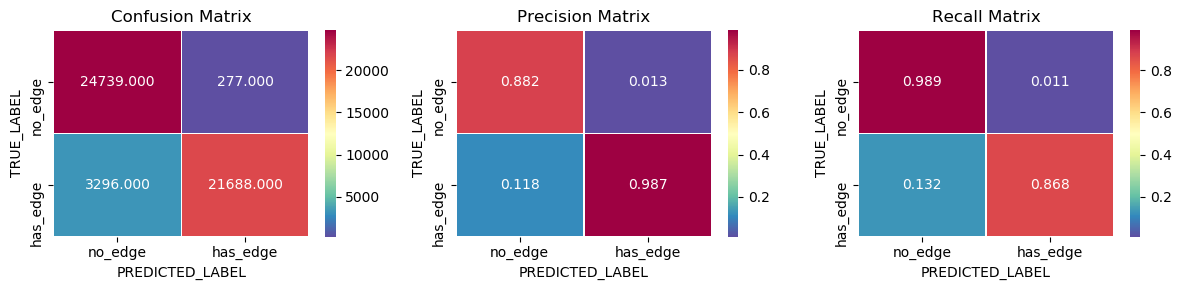

In [51]:
models_eval_dict['LOGISTIC_REGRESSION'] = get_metrics(model=log_clf,
                                                      x_train=Xtrain_n,
                                                      x_test=Xtest_n,
                                                      name='LOGISTIC_REGRESSION')

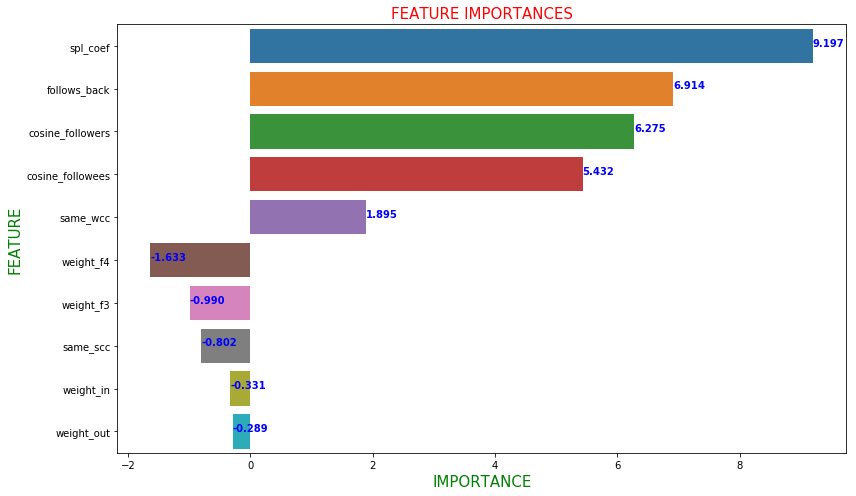

In [52]:
plot_top_features(log_clf.coef_)

__<font color='green'>OBSERVATIONS</font>__

* Logistic Regression being a simple linear model had very good performance.
* The precision is 99% There is more room for improvement in the recall.
* The log_loss is slightly on the higher side.
* The top features seem pretty straight forward.

## 7.4 Decision Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [28]:
%%time

params = {'max_depth' : np.arange(2, 30, 2),
          'min_samples_split' : np.arange(5, 50),
          'min_samples_leaf' : np.arange(5, 50)}

dt_clf_rs_cv = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                                  param_distributions=params,
                                  n_iter=200,
                                  n_jobs=-1,
                                  cv=3,
                                  scoring='f1')

dt_clf_rs_cv.fit(Xtrain, Ytrain)

Wall time: 4min 3s


In [29]:
dt_clf = dt_clf_rs_cv.best_estimator_
dt_clf_rs_cv.best_params_

{'min_samples_split': 48, 'min_samples_leaf': 35, 'max_depth': 12}

,PRECISION,RECALL,ACCURACY,LOG_LOSS,F1_SCORE
DECISION_TREES,0.9802,0.8898,0.936,0.2199,0.9328


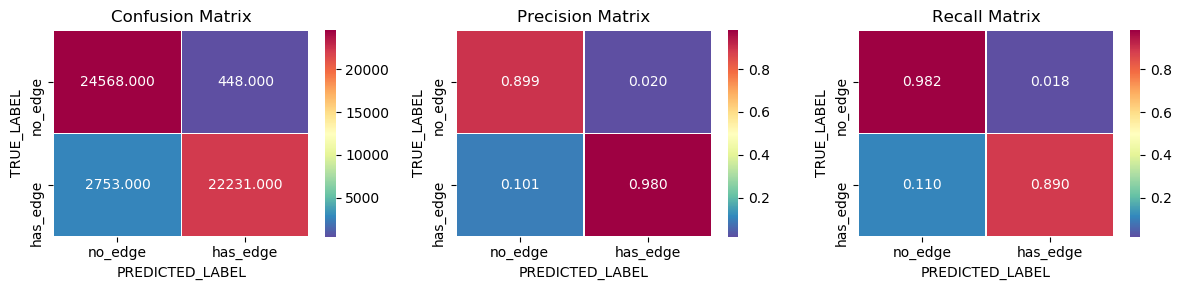

In [30]:
models_eval_dict['DECISION_TREES'] = get_metrics(model=dt_clf, name='DECISION_TREES')

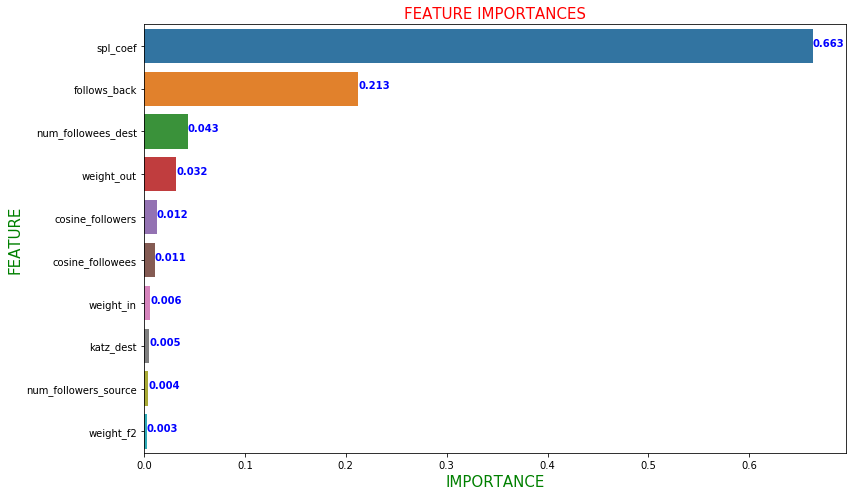

In [31]:
plot_top_features(dt_clf.feature_importances_)

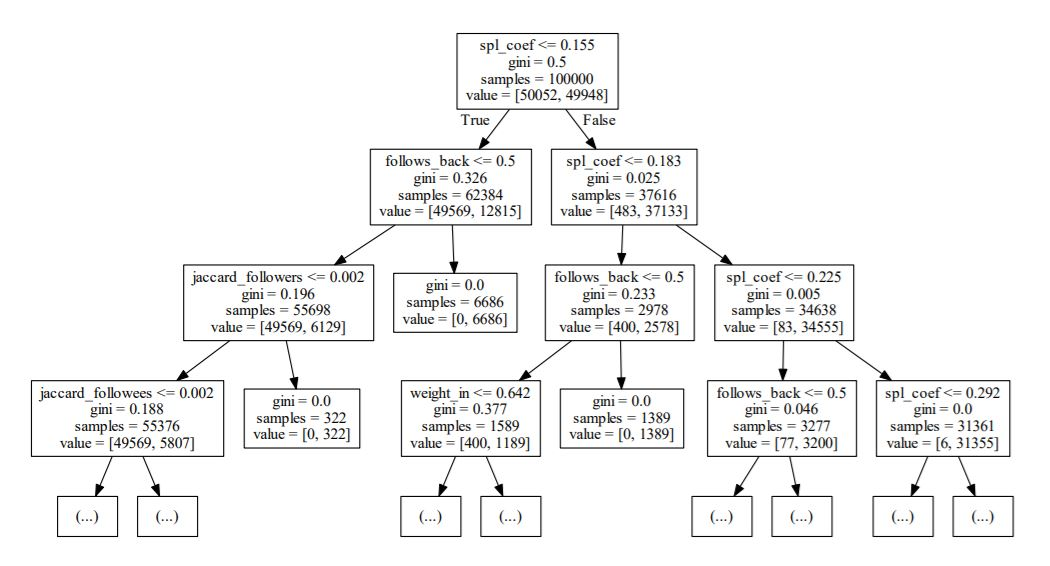

In [32]:
#render_graph(dt_clf, depth=3, features=columns, filename='dt_graph')
Image('decision_tree_features.JPG', width=600, height=300)

__<font color='green'>OBSERVATIONS</font>__

* The performance compared to logistic regression has slightly improved.
* The recall value has improved a little.
* The log_loss seem to be terrific.
* The `spl_coef` we built using inverse of shortest_path_length has highest importance.

## 7.5 Random Forests

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
%%time

params = {'max_depth' : np.arange(3, 16, 2), 
          'n_estimators' : [10, 50, 100, 200, 400],
          'min_samples_split' : np.arange(5, 50),
          'min_samples_leaf' : np.arange(5, 50)}


rf_clf_rs_cv = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                  param_distributions=params,
                                  n_iter=100,
                                  n_jobs=-1,
                                  cv=3,
                                  scoring='f1')

rf_clf_rs_cv.fit(Xtrain, Ytrain)

Wall time: 23min 29s


In [35]:
rf_clf = rf_clf_rs_cv.best_estimator_
rf_clf_rs_cv.best_params_

{'n_estimators': 100,
 'min_samples_split': 40,
 'min_samples_leaf': 5,
 'max_depth': 15}

,PRECISION,RECALL,ACCURACY,LOG_LOSS,F1_SCORE
RANDOM_FORESTS,0.9783,0.8849,0.9327,0.2363,0.9293


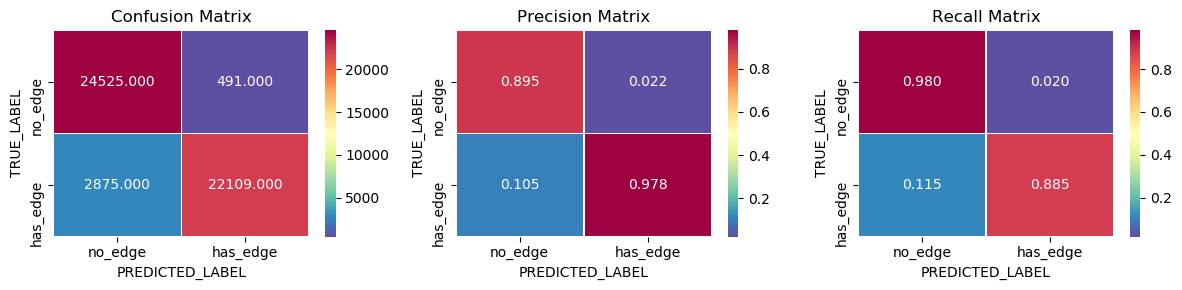

In [36]:
models_eval_dict['RANDOM_FORESTS'] = get_metrics(model=rf_clf, name='RANDOM_FORESTS')

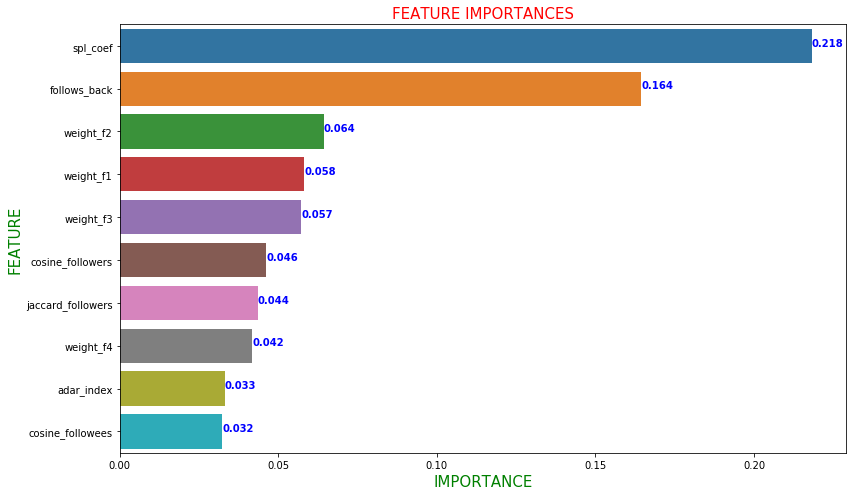

In [37]:
plot_top_features(rf_clf.feature_importances_)

__<font color='green'>OBSERVATIONS</font>__

* Random Forests performed just as same as the Decision Trees Classifier.
* This might be due to the linear structure of the data.

## 7.6 XGBoost

In [38]:
from xgboost import XGBClassifier

In [39]:
%%time

parameters = {'n_estimators' : [20, 40, 80, 160, 320],
              'max_depth' : np.arange(3, 16, 2),
              'min_child_weight' : [2, 3, 4, 5, 6],
              'learning_rate' : [0.1, 0.3,  0.5, 0.7,  0.9],
              'colsample_bytree' : [0.5, 0.75, 1]}

xgb_rs_cv = RandomizedSearchCV(XGBClassifier(),
                               param_distributions=parameters,
                               cv=3,
                               n_iter=50,
                               n_jobs=-1,
                               scoring='f1')
xgb_rs_cv.fit(Xtrain, Ytrain)

Wall time: 55min 20s


In [40]:
xgb_clf = xgb_rs_cv.best_estimator_
xgb_rs_cv.best_params_

{'n_estimators': 320,
 'min_child_weight': 3,
 'max_depth': 11,
 'learning_rate': 0.3,
 'colsample_bytree': 1}

,PRECISION,RECALL,ACCURACY,LOG_LOSS,F1_SCORE
XGBOOST,0.9809,0.8822,0.9326,0.2443,0.929


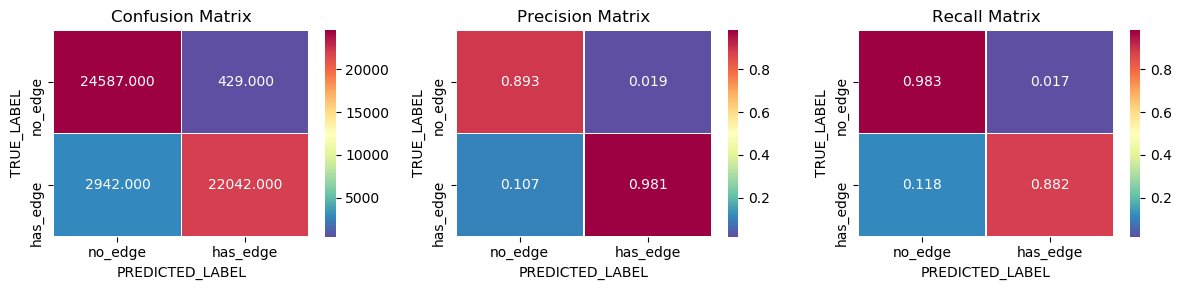

In [41]:
models_eval_dict['XGBOOST'] = get_metrics(model=xgb_clf, name='XGBOOST')

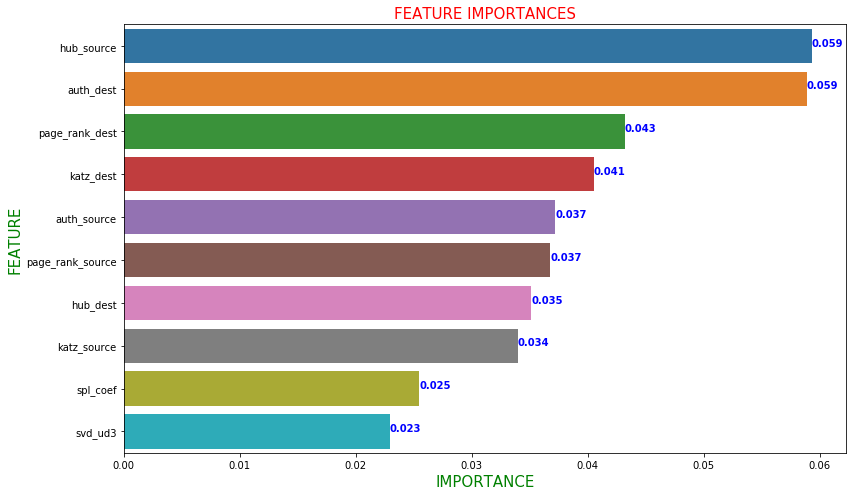

In [42]:
plot_top_features(xgb_clf.feature_importances_)

__<font color='green'>OBSERVATIONS</font>__

* The performance is same as the above tree based models.
* Although the feature importances have changes dramatically.

__SAVING THE MODELS TO DISK__

In [43]:
with open('all_models_cv.pkl', 'wb') as f:
    pickle.dump((knn_gs_cv, log_reg_gs_cv, dt_clf_rs_cv, rf_clf_rs_cv, xgb_rs_cv), f)

# 8. Conclusion

In [53]:
metric_names = models_eval_dict.pop('columns')
pd.DataFrame.from_dict(models_eval_dict, orient='index', columns=metric_names).sort_values('F1_SCORE', ascending=False)

,PRECISION,RECALL,ACCURACY,LOG_LOSS,F1_SCORE
DECISION_TREES,0.9802,0.8898,0.9360,0.2199,0.9328
RANDOM_FORESTS,0.9783,0.8849,0.9327,0.2363,0.9293
XGBOOST,0.9809,0.8822,0.9326,0.2443,0.9290
LOGISTIC_REGRESSION,0.9874,0.8681,0.9285,0.2708,0.9239
KNN,0.8796,0.7765,0.8352,0.4079,0.8248


* __The performance of the models was great measured by their complexities and the structure of our data.__

* __Our extensive feature_enginineering has returned us great results.__

* __Performance of the tree based models was on a similar scale.__

* __A simple Decision Tree was able to trump the complex non-linear models.__

# 9. Acknowledgements

* [Link Prediction Algoritmns](http://be.amazd.com/link-prediction/)
* [Graph-based Features for Supervised Link Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf)